# Imports

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
from itertools import product

# Definitions

## Task

In [80]:
class Task:
    def __init__(self, size=None):
        if size == None:
            size = 100
        self.size = np.random.randint(size, 2 * size)
        self.Weight_limit = np.random.randint(10 * self.size, 20 * self.size)
        self.Size_limit = np.random.randint(10 * self.size, 20 * self.size)
        while True:
            self.weights = np.round(np.random.random(self.size) * 10 * self.Weight_limit / self.size, 5)
            self.sizes = np.round(np.random.random(self.size) * 10 * self.Size_limit / self.size, 5)
            self.costs = np.round(np.random.random(self.size) * self.size, 5)
            if self.weights.sum() > 2 * self.Weight_limit and self.sizes.sum() > 2 * self.Size_limit:
                break

In [81]:
generated_task = Task(size=25)
generated_task.__dict__

{'size': 41,
 'Weight_limit': 515,
 'Size_limit': 516,
 'weights': array([  6.15003,  76.19743,  67.65043,  29.81395,  22.73153,  69.20035,
         52.60265,  93.19277,  83.28001, 114.34216,  26.90496,  82.71732,
         89.17539,   9.47756,  31.59464,   5.78609, 123.86716,  56.48901,
         27.78889,  26.61763,  22.98608,  16.08449,  73.8666 ,  34.44896,
         55.40243, 121.86507,  25.15413,  93.51831,  44.35201,  48.61952,
         47.74181,  94.89844, 123.11953,  37.12008,  80.03529, 109.40113,
         33.3414 ,   7.17523,  56.11058,  59.05343,  75.21092]),
 'sizes': array([ 49.70808,  60.43423, 123.66657,   1.42585,  19.58603,  71.03559,
          3.04696, 125.16475,  54.02761, 103.63894,  53.54372, 111.88936,
         43.17236,  19.07651,  45.67237,  12.30627,  66.8168 , 123.62886,
         14.7134 ,  45.69256,  43.75412,  62.95017,  85.574  , 100.89119,
        122.30331,  65.6382 ,   6.17064,  43.22392,  73.56629,  73.03676,
        123.25596,  97.57604,  49.51531,  89.2

## Indyvidual

In [82]:
class Individual:
    def __init__(self, genome):
        self.genome = genome

    def evaluate(self, task):
        weight_sum = (self.genome * task.weights).sum()
        sizes_sum = (self.genome * task.sizes).sum()
        costs_sum = (self.genome * task.costs).sum()
        if weight_sum <= task.Weight_limit and sizes_sum <= task.Size_limit:
            return costs_sum
        else:
            return 0

    def mutate(self, mutation_rate):
        genome_size = self.genome.shape[0]
        no_of_genes_to_change = int(np.ceil(genome_size * mutation_rate))
        genes_to_change = random.choices(range(genome_size), k=no_of_genes_to_change)
        self.genome[genes_to_change] = -self.genome[genes_to_change] + 1

## Population

In [84]:
class Population:
    def __init__(self, genome_size=None, pop_size=None):
        self.population = []
        if genome_size != None and pop_size != None:
            population_array = np.random.choice(
                [0, 1], size=(pop_size, genome_size), p=[0.85, 0.15]
            )
            for genome in population_array:
                individual = Individual(genome)
                self.population.append(individual)
        self.size = len(self.population)

    def tournament(self, tournament_size, task):
        selected = random.choices(self.population, k=tournament_size)
        evaluation = [elem.evaluate(task) for elem in selected]
        idx_best_individual = evaluation.index(max(evaluation))
        return selected[idx_best_individual]

    def crossover(self, crossover_rate, parent_1, parent_2, task):
        if np.random.random() < crossover_rate:
            splitting_point = np.random.randint(1, len(parent_1.genome))
            result_genome = np.concatenate(
                [parent_1.genome[:splitting_point], parent_2.genome[splitting_point:]]
            )
            result = Individual(result_genome)
        else:
            result = parent_1
        return result

    def add_child(self, child):
        self.population.append(child)
        self.size = len(self.population)

    def best(self, task):
        evaluation = [individual.evaluate(task) for individual in self.population]
        idx_best_individual = evaluation.index(max(evaluation))
        best = self.population[idx_best_individual]
        return best, best.evaluate(task)

    def evaluate(self, task):
        evaluation = np.array(
            [individual.evaluate(task) for individual in self.population]
        )
        return evaluation

## Genetic Algorithm

In [145]:
class GeneticAlgorithm:
    def __init__(
        self, populations_size, tournament_size, crossover_rate, mutation_rate
    ):
        self.populations_size = populations_size
        self.tournament_size = tournament_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def fit(self, iterations, task, show_tqdm=False):
        population = Population(genome_size=task.size, pop_size=self.populations_size)
        best_history = []
        best_genome_history = []
        mean_evalueation_history = []
        the_best_individual, the_best_evaluation = population.best(task)
        if show_tqdm:
            iterator = tqdm(range(iterations))
        else:
            iterator = range(iterations)
        for _ in iterator:
            new_population = Population()
            for _ in range(population.size):
                parent_1 = population.tournament(self.tournament_size, task)
                parent_2 = population.tournament(self.tournament_size, task)
                child = population.crossover(self.crossover_rate, parent_1, parent_2, task)
                child.mutate(self.mutation_rate)
                new_population.add_child(child)

            best_individual, best_evaluation = population.best(task)
            best_genome_history.append(best_individual.genome)
            if best_evaluation > the_best_evaluation:
                the_best_individual = best_individual
                the_best_evaluation = best_evaluation
            best_history.append(best_evaluation)

            mean_evalueation_history.append(population.evaluate(task).mean())

            population = new_population

        return (
            the_best_individual,
            best_history,
            best_genome_history,
            mean_evalueation_history,
        )
    
    def test_param(self, params, cases, iterations, task):
        param_name = list(params.keys())[0]
        test_set = list(params.values())[0]
        measured_param_history = []
        total=cases * len(test_set)
        t = tqdm(
            enumerate(list(product(test_set, range(cases)))),
            total=total
        )
        for i, (param, test_case) in t:
            test_histories = []
            if param_name == "Crossover rate":
                self.crossover_rate = param
            elif param_name == "Mutation rate":
                self.mutation_rate = param
            elif param_name == "Population size":
                self.populations_size = param
            elif param_name == "Tournament size":
                self.tournament_size = param
            else:
                raise Exception("param_name", "wrong")

            best, best_history, best_evaluation, mean_evalueation_history = self.fit(iterations, task)
            test_histories.append(best_history)
            measured_param_history.append(test_histories)
        return measured_param_history

In [ ]:
parameters = {
    'populations_size': 50,
    'tournament_size': 10,
    'crossover_rate': 0.9,
    'mutation_rate':  0.0001, 
}

genetic_algorithm = GeneticAlgorithm(**parameters)

In [99]:
best, best_history, best_evaluation, mean_evalueation_history = genetic_algorithm.fit(iterations=200, task=generated_task)

In [100]:
best.genome

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1])

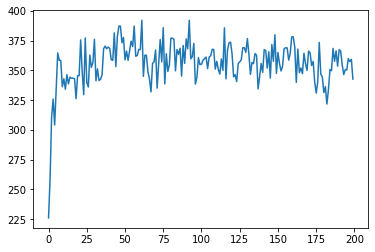

In [101]:
plt.plot(best_history);

In [102]:
print(*best_evaluation[:5], sep='\n')

[0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 1]
[0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 1]
[1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 1]
[0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 1]
[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 0 1]


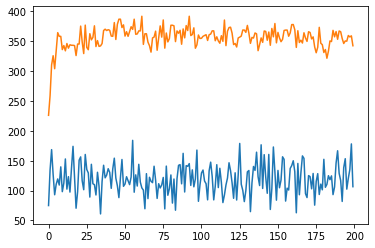

In [103]:
plt.plot(mean_evalueation_history)
plt.plot(best_history);


# Testing Hyperparameters

In [208]:
class TestGeneticAlgorithm:
    def __init__(self, parameters, task, cases, iterations):
        self.iterations = iterations
        self.parameters = parameters
        self.cases = cases
        self.task = task
        self.genetic_algorithm = GeneticAlgorithm(**self.parameters)
    
    def plot_tests_history(self):
        param_name = list(self.test_params.keys())[0]
        test_set = list(self.test_params.values())[0]

        subplots_no = self.measured_param_history.shape[0]
        iterations_no = self.measured_param_history.shape[2]
        
        fig, axs = plt.subplots(1, subplots_no, sharey=True)
        fig.set_size_inches(20, 5)
        fig.suptitle("Evaluation " + param_name, fontsize=20)
        for i, test_histories in enumerate(self.measured_param_history):
            min_val = round(test_histories.min(), 2)
            max_val = round(test_histories.max(), 2)

            test_histories_array = np.array(test_histories)
            y = test_histories_array.mean(axis=0)
            x = np.array(range(test_histories_array.shape[1]))
            y_err = test_histories_array.std(axis=0)
#             ax = plt.subplot(1, subplots_no, i + 1)
            ax = axs[i]
            ax.set_title("{}: {} | Best: {}".format(param_name, test_set[i], str(max_val)), fontsize=15)
            ax.errorbar(
                x=x,
                y=y,
                yerr=y_err,
                ecolor="#ffb3b3",
                elinewidth=25,
                color="black",
                linewidth=4,
                capsize=2,
            )
            ax.set_xlabel("Iterations", fontsize=12)
            axs[0].set_ylabel("Mean evaluation", fontsize=12)
        plt.show()
        
        
    def run(self, test_params):
        self.test_params = test_params
        test_params_no = len(list(test_params.values())[0])
        
        self.measured_param_history = self.genetic_algorithm.test_param(
            cases=self.cases, 
            params=self.test_params, 
            iterations=self.iterations, 
            task=self.task
        )
        self.measured_param_history = np.array(self.measured_param_history).reshape(test_params_no, self.cases, self.iterations)
        self.plot_tests_history()

In [231]:
generated_task = Task(size=25)
parameters = {
    'populations_size': 50,
    'tournament_size': 10,
    'crossover_rate': 0.9,
    'mutation_rate':  0.0001, 
}
ITERATIONS = 40
TEST_CASES = 4

test_gen_alg = TestGeneticAlgorithm(
    parameters=parameters,
    task=generated_task,
    cases=TEST_CASES, 
    iterations=ITERATIONS
)

  0%|          | 0/12 [00:00<?, ?it/s]

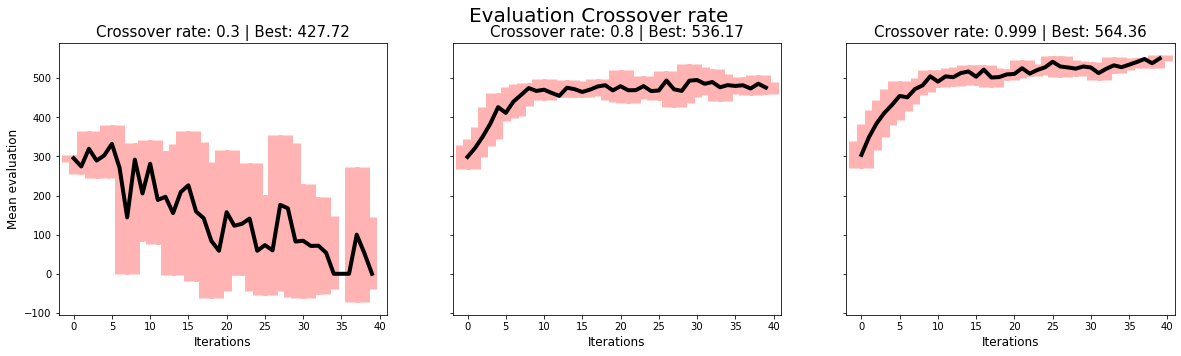

In [234]:
test_gen_alg.run(test_params={"Crossover rate": [0.3, 0.8, 0.999]})

  0%|          | 0/12 [00:00<?, ?it/s]

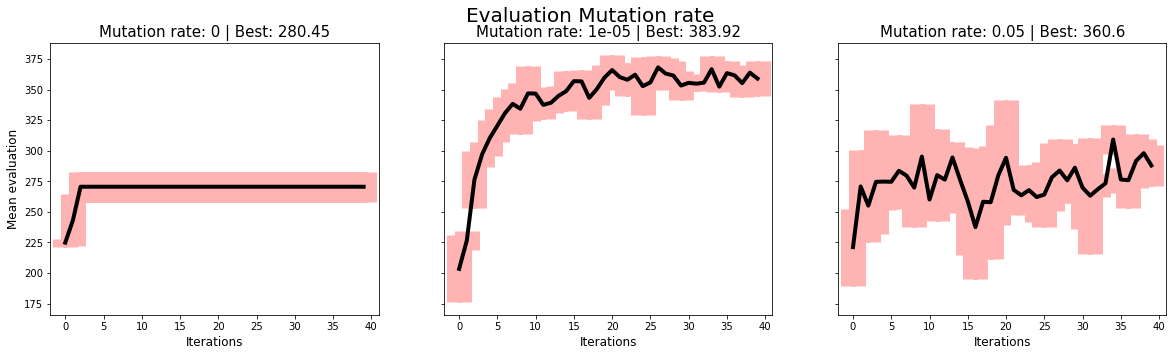

In [225]:
test_gen_alg.run(test_params={"Mutation rate": [0, 0.00001, 0.05]})

  0%|          | 0/12 [00:00<?, ?it/s]

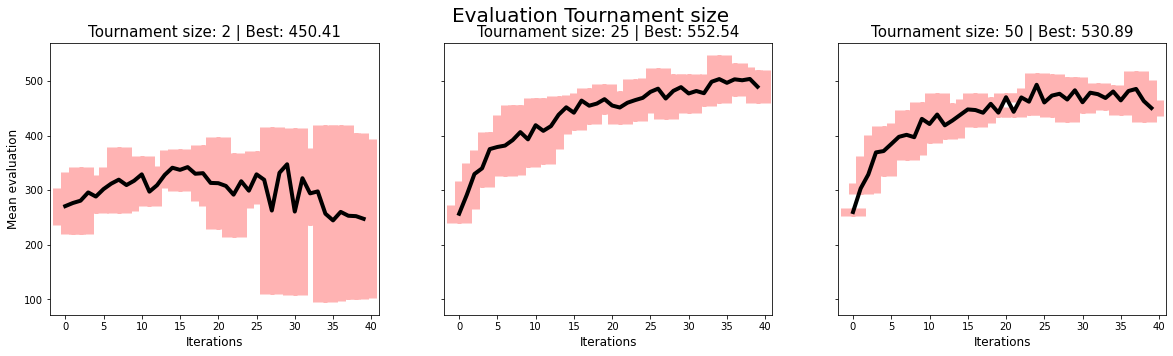

In [238]:
test_gen_alg.run(test_params={"Tournament size": [2, 25, 50]})

  0%|          | 0/12 [00:00<?, ?it/s]

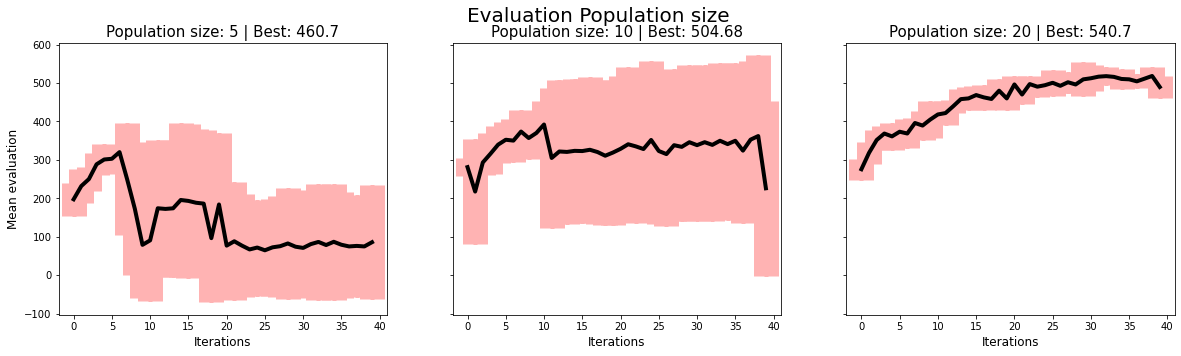

In [237]:
test_gen_alg.run(test_params={"Population size": [5,10,20]})

# Final Run

In [239]:
parameters = {
    'populations_size': 100,
    'tournament_size': 50,
    'crossover_rate': 0.9,
    'mutation_rate':  0.0001, 
}

ITERATIONS = 200
TEST_CASES = 5

generated_task = Task(size=50)
genetic_algorithm = GeneticAlgorithm(**parameters)
the_best_individual, best_history, best_genome_history, mean_evalueation_history = genetic_algorithm.fit(iterations=ITERATIONS, task=generated_task, show_tqdm=True)

  0%|          | 0/200 [00:00<?, ?it/s]

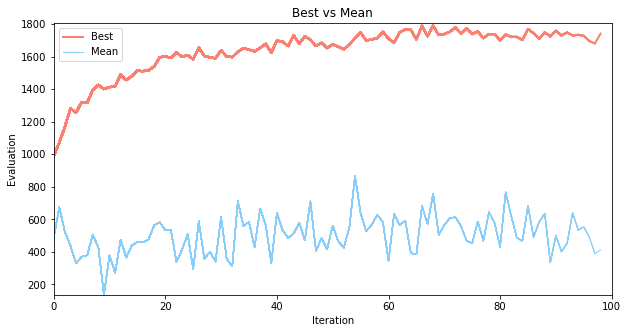

In [242]:
from matplotlib.animation import FuncAnimation
from matplotlib.legend_handler import HandlerLine2D

plt.style.use("seaborn-pastel")
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

limit=100

def init():
    ax.set(
        xlim=(0, limit),
        ylim=[min(mean_evalueation_history), max(best_history)],
        title="Best vs Mean",
        xlabel="Iteration",
        ylabel="Evaluation",
    )


def update(i):
    l1 = plt.plot(np.array(best_history[:i]), linewidth=2, color="salmon")
    l2 = plt.plot(np.array(mean_evalueation_history[:i]), linewidth=1, color="lightskyblue")
    plt.legend(["Best", "Mean"], loc="upper left")


anim = FuncAnimation(fig, update, frames=100, init_func=init, interval=1)
anim.save("animation.gif", writer="imagemagick")
plt.show()

# Animation
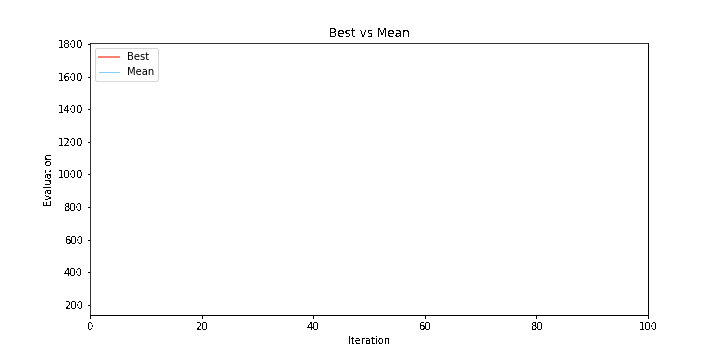


# Genomes Change

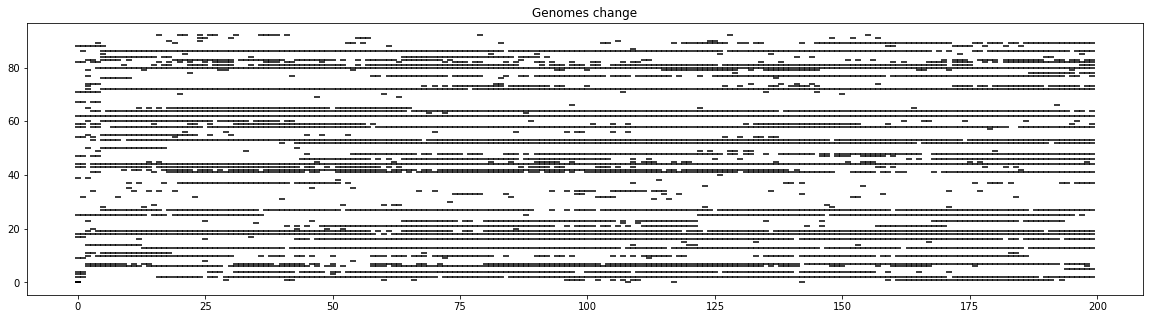

In [243]:
data = np.array(best_genome_history)
fig, ax = plt.subplots()

fig.set_size_inches(20,5)
for col_no in range(data.shape[1]):
    col = data[:, col_no].copy()
    x = col*range(col.shape[0])
    col *= col_no
    plt.scatter(x, col, marker='_', c='k')
    plt.title("Genomes change")
